In [1]:
import numpy as np
import os
from sklearn.model_selection import KFold
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tensorflow.keras.layers import Dense , Dropout
from scikeras.wrappers import KerasRegressor 
from tensorflow.keras.callbacks import EarlyStopping
import time
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV


# Datenvorverarbeitung

In [2]:
#data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/TPath_300_finish_data.pkl')
data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/Finish_D2_I7000_F9000/TPath_500_finish_data_D2.pkl')

data

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
0,0.0000,-0.00200,500,7000,9000,669.05
1,0.0000,-0.00198,500,7000,9000,682.81
2,0.0000,-0.00196,500,7000,9000,696.80
3,0.0000,-0.00194,500,7000,9000,710.67
4,0.0000,-0.00192,500,7000,9000,724.42
...,...,...,...,...,...,...
25321,0.0025,0.00192,500,7000,9000,584.84
25322,0.0025,0.00194,500,7000,9000,581.64
25323,0.0025,0.00196,500,7000,9000,578.47
25324,0.0025,0.00198,500,7000,9000,575.32


In [3]:
# Droppen unnötiger Spalten
df = data.drop(data.columns[2:5], axis = 1)
df

,X-Koordinate,Y-Koordinate,Temperatur
0,0.0000,-0.00200,669.05
1,0.0000,-0.00198,682.81
2,0.0000,-0.00196,696.80
3,0.0000,-0.00194,710.67
4,0.0000,-0.00192,724.42
...,...,...,...
25321,0.0025,0.00192,584.84
25322,0.0025,0.00194,581.64
25323,0.0025,0.00196,578.47
25324,0.0025,0.00198,575.32


In [27]:
# Randomisieren der Anordnung
df1 = df.sample(frac=1, random_state=42)  # Hier wird 42 als Random State verwendet, um die Ergebnisse reproduzierbar zu machen
print(df1)
df_reset = df1.reset_index(drop=True)
df_reset

       X-Koordinate  Y-Koordinate  Temperatur
5099        0.00050      -0.00052     1471.00
12799       0.00126       0.00072     1319.30
15071       0.00148       0.00194      595.19
24620       0.00244      -0.00004     1249.00
11071       0.00110      -0.00168      884.35
...             ...           ...         ...
21575       0.00214      -0.00064     1263.60
5390        0.00052       0.00128     1035.40
860         0.00008      -0.00088     1376.50
15795       0.00156       0.00034     1383.80
23654       0.00234       0.00074     1149.60

[25326 rows x 3 columns]


,X-Koordinate,Y-Koordinate,Temperatur
0,0.00050,-0.00052,1471.00
1,0.00126,0.00072,1319.30
2,0.00148,0.00194,595.19
3,0.00244,-0.00004,1249.00
4,0.00110,-0.00168,884.35
...,...,...,...
25321,0.00214,-0.00064,1263.60
25322,0.00052,0.00128,1035.40
25323,0.00008,-0.00088,1376.50
25324,0.00156,0.00034,1383.80


In [28]:
# Gesamtdaten festlegen

label = df_reset["Temperatur"]
df1 = df_reset.drop("Temperatur", axis=1)
X = df1
y = label

In [29]:
X

,X-Koordinate,Y-Koordinate
0,0.00050,-0.00052
1,0.00126,0.00072
2,0.00148,0.00194
3,0.00244,-0.00004
4,0.00110,-0.00168
...,...,...
25321,0.00214,-0.00064
25322,0.00052,0.00128
25323,0.00008,-0.00088
25324,0.00156,0.00034


In [30]:
y

0        1471.00
1        1319.30
2         595.19
3        1249.00
4         884.35
          ...   
25321    1263.60
25322    1035.40
25323    1376.50
25324    1383.80
25325    1149.60
Name: Temperatur, Length: 25326, dtype: float64

In [31]:
# Unterteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [32]:
# Initialisiere einen MinMaxScaler für die Features
scaler_features = MinMaxScaler()
# Skaliere X_train und X_test
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test) 

# Initialisiere einen SEPARATEN MinMaxScaler für das Ziel
scaler_target = MinMaxScaler()
# erwartet, dass die Eingaben als 2D-Arrays kommen, und Ziele normalerweise als 1D-Arrays vorliegen.
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))


In [33]:
X_train_scaled

array([[1.   , 0.15 ],
       [0.984, 0.49 ],
       [0.224, 0.905],
       ...,
       [0.04 , 0.585],
       [0.976, 0.815],
       [0.744, 0.785]])

# Netzwerkarchitektur

In [34]:
# Netzwerkarchitektur
model = Sequential([

    Dense(136, activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

    Dense(216, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(104, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(328, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(8, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

    Dense(120, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

    Dense(1 , activation = 'linear')
])

# Optimierer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Modell kompilieren (Verwendung von mean_squared_error als Verlustfunktion für Regression)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])  # Metriken für Regression: Mean Absolute Error und Mean Squared Error

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Trainingsparameter
batch_size = 150
epochs = 2000

# Modell trainieren (Annahme: X_train, y_train, X_val, y_val sind vordefiniert)
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping])
model.save('D2_1.h5')

Epoch 1/2000
109/109 [==============================] - 1s 4ms/step - loss: 0.1610 - mae: 0.3004 - val_loss: 0.1207 - val_mae: 0.2514
Epoch 2/2000
109/109 [==============================] - 0s 2ms/step - loss: 0.0935 - mae: 0.2162 - val_loss: 0.0683 - val_mae: 0.1772
Epoch 3/2000
109/109 [==============================] - 0s 2ms/step - loss: 0.0467 - mae: 0.1322 - val_loss: 0.0303 - val_mae: 0.0865
Epoch 4/2000
109/109 [==============================] - 0s 2ms/step - loss: 0.0240 - mae: 0.0631 - val_loss: 0.0193 - val_mae: 0.0416
Epoch 5/2000
109/109 [==============================] - 0s 3ms/step - loss: 0.0177 - mae: 0.0333 - val_loss: 0.0164 - val_mae: 0.0253
Epoch 6/2000
109/109 [==============================] - 0s 2ms/step - loss: 0.0158 - mae: 0.0220 - val_loss: 0.0154 - val_mae: 0.0213
Epoch 7/2000
109/109 [==============================] - 0s 2ms/step - loss: 0.0150 - mae: 0.0181 - val_loss: 0.0149 - val_mae: 0.0189
Epoch 8/2000
109/109 [==============================] - 0s 2ms

C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [59]:
 # Initialisiere Listen, um Ergebnisse zu speichern
val_loss_results = []
val_mae_results = []

# Funktion, um das Modell zu erstellen
def create_model():
    model = Sequential([
                Dense(136, activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

                Dense(216, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

                Dense(104, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

                Dense(328, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

                Dense(8, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

                Dense(120, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

                Dense(1 , activation = 'linear')
    ])
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# K-Fold Cross-Validation Konfiguration
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Leistungsüberwachung
fold_no = 1
for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train_scaled[train_index], y_train_scaled[val_index]

    model = create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

    print(f'Training für Fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold, batch_size=150, epochs=1000, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=1)

    # Speichere die Ergebnisse des aktuellen Folds
    val_loss_results.append(min(history.history['val_loss']))
    val_mae_results.append(min(history.history['val_mae']))

    fold_no += 1

# Berechne den Durchschnitt über alle Folds
average_val_loss = np.mean(val_loss_results)
average_val_mae = np.mean(val_mae_results)

# Gib die durchschnittlichen Ergebnisse aus
print(f'Durchschnittlicher Validation Loss: {average_val_loss}')
print(f'Durchschnittlicher Validation MAE: {average_val_mae}')

# Umwandeln der Listen in Pandas DataFrames
val_loss_df = pd.DataFrame(val_loss_results, columns=['Validation Loss'])
val_mae_df = pd.DataFrame(val_mae_results, columns=['Validation MAE'])

# Speichern der DataFrames in CSV-Dateien
val_loss_df.to_csv('val_loss_results_D2_1.csv', index=False)
val_mae_df.to_csv('val_mae_results_D2_1.csv', index=False)

# Gib die durchschnittlichen Ergebnisse aus
print(f'Durchschnittlicher Validation Loss: {average_val_loss}')
print(f'Durchschnittlicher Validation MAE: {average_val_mae}')

In [35]:
# Auswertung des Modells auf den Testdaten
results = model.evaluate(X_test_scaled, y_test_scaled, verbose=2)
results

159/159 - 0s - loss: 5.3508e-04 - mae: 0.0012 - 167ms/epoch - 1ms/step


[0.000535078754182905, 0.0012097759172320366]

In [36]:
#Rückrechnung des skalierten MAE zum unskalierten MAE für eines bessere Einschätzung des Ergebnisses
scaled_predicted_values = model.predict(X_test_scaled, verbose = 0)

# Führen Sie die Rücktransformation der skalierten Werte durch
original_predicted_values = scaler_target.inverse_transform(scaled_predicted_values)
original_actual_values = scaler_target.inverse_transform(y_test_scaled)  # y_test sind die skalierten tatsächlichen Werte
print(f' Bsp. Predicted: {original_predicted_values[100]} Actual: {original_actual_values[100]} ')

def calculate_mae(list1, list2):
    # Stelle sicher, dass beide Listen die gleiche Länge haben
    if len(list1) != len(list2):
        raise ValueError("Listen müssen die gleiche Länge haben")

    # Berechne die absolute Differenz zwischen den Elementen der Listen
    differences = [abs(x - y) for x, y in zip(list1, list2)]

    # Berechne den Durchschnitt der absoluten Differenzen
    mae = sum(differences) / len(differences)

    return mae

# Beispiel
list1 = original_predicted_values
list2 = original_actual_values

mae = calculate_mae(list1, list2)
print(f"Durchschnittliche Abweichung (MAE): {mae}")

# Berechnung MAPE
errors = np.abs((original_actual_values - original_predicted_values) / original_actual_values)
mape = np.mean(errors) * 100
print(mape)

 Bsp. Predicted: [1287.6149] Actual: [1286.9] 
Durchschnittliche Abweichung (MAE): [1.14663258]


In [69]:
# Berechnung der Auswertungsgröße R^2
def calculate_r_squared(predicted, actual):
    # Berechnung des Mittelwerts der tatsächlichen Werte
    mean_actual = sum(actual) / len(actual)
    
    # Berechnung der totalen Summe der Quadrate (SST)
    sst = sum((x - mean_actual) ** 2 for x in actual)
    
    # Berechnung der Summe der Quadrate der Residuen (SSE)
    sse = sum((actual[i] - predicted[i]) ** 2 for i in range(len(actual)))
    
    # Berechnung des R^2-Wertes
    r_squared = 1 - (sse / sst)
    
    return r_squared

# Berechnung von R^2 mit den bereitgestellten Listen
r_squared = calculate_r_squared(list1, list2)

print(f"R^2: {r_squared}")

R^2: [0.99966131]


# Plotten des Trainingsprozesses

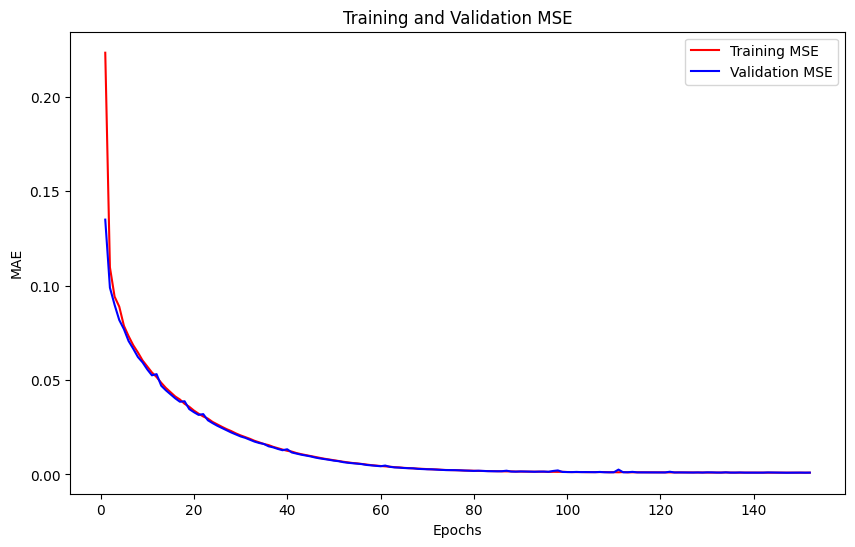

In [63]:
mse = history.history['loss']
val_mse = history.history['val_loss']

epochs = range(1, len(mae) + 1)

# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mse, 'r', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Bilder Diplomarbeit/MSE_NeuroNetz/MSE_NeuroNetz_D2_2')
plt.show()


In [64]:
# Zeigt die größten Differenzen von vorhergesagten Wert und echten Wert an
df_result = pd.DataFrame({'Echt': [val[0] for val in list2], 'Vorhergesagt': [val[0] for val in list1]})
df_result['X-Koordinate'] = X_test_scaled[:, 0]
df_result['Y-Koordinate'] = X_test_scaled[:, 1]

df_result['Differenz'] = abs(df_result['Echt'] - df_result['Vorhergesagt'])
df_result['Differenz'].sort_values()
sorted_df = df_result.sort_values(by= 'Differenz')
Anzahl_Punkte = (sorted_df['Differenz'] > -10).sum()
print("Anzahl der Werte die kleiner sind:", Anzahl_Punkte)

sorted_df

Anzahl der Werte die kleiner sind: 4933


,Echt,Vorhergesagt,X-Koordinate,Y-Koordinate,Differenz
2493,811.525146,836.38,0.992,0.900,-24.854854
2316,732.671204,755.11,0.992,0.930,-22.438796
2187,772.044312,793.93,0.976,0.915,-21.885688
2696,798.328857,820.06,0.976,0.905,-21.731143
914,811.471313,832.31,0.976,0.900,-20.838687
...,...,...,...,...,...
4223,692.116394,670.60,0.960,0.000,21.516394
1631,685.484131,663.16,0.888,0.000,22.324131
1499,688.454651,665.99,0.920,0.000,22.464651
2686,691.384094,668.83,0.952,0.000,22.554094


# GridSearch

In [65]:
def build_model(learning_rate=0.001, activation='relu', regularization=0.0001, dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(136, activation=activation, input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(216, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(104, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(328, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(8, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(120, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
    return model

# Verwenden Sie eine Funktion, um das Modell zu instanziieren, für scikit-learn Wrapper
model = KerasRegressor(model=build_model, verbose=2)

# Anpassung der Parameter im param_grid
param_grid = {
    'model__learning_rate': [0.01, 0.001, 0.0001],
    'model__regularization': [0.001, 0.0001],
    'fit__batch_size': [50, 100, 150, 200],
    'fit__epochs': [50],
    'model__dropout_rate' : [0.0, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
# Hinweis: Stellen Sie sicher, dass Ihre Daten (X_train_scaled, y_train_scaled) korrekt definiert sind
grid_result = grid_search.fit(X_train_scaled, y_train_scaled)
# Beste Parameter und Score ausgeben
print("Beste Parameter:", grid_search.best_params_)
print("Beste Genauigkeit:", grid_search.best_score_)

with open("Gridsearch_D2_1.txt", "w") as f:
    f.write(f"Beste Parameter: {grid_search.best_params_}\n")
    f.write(f"Beste Genauigkeit: {grid_search.best_score_}")


# Random Search Architektur

In [66]:
# Funktion zum Erstellen des Modells
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('input_units', min_value=8, max_value=328, step=16), input_shape=(2,), activation='relu'))
    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(Dense(hp.Int(f'units_{i}', min_value=8, max_value=328, step=16), activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Durchführung der Random Search dreimal
for run in range(1, 4):
    # Anpassen des Verzeichnisses und des Projektnamens für jeden Durchlauf
    directory = 'random_search'
    project_name = f'random_search_D2_{run}'

    tuner = RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=100,
        executions_per_trial=1,
        directory=directory,
        project_name=project_name
    )

    # Durchführung des Random Search
    tuner.search(X_train_scaled, y_train_scaled, epochs=200, verbose =0, batch_size=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

    # Abrufen und Speichern des besten Modells
    best_model = tuner.get_best_models(num_models=1)[0]
    model_path = os.path.join(directory, project_name, 'best_model.h5') 
    best_model.save(model_path)


    # Optional: Abrufen und Ausgeben der besten Hyperparameter
    best_hyperparameters = tuner.get_best_hyperparameters()[0]

    # Konvertieren der Hyperparameter in ein DataFrame
    df_hyperparameters = pd.DataFrame([best_hyperparameters.values])
    # Speichern des DataFrame als CSV
    df_hyperparameters.to_csv(f'random_search_D2_{run}.csv', index=False)

    print(f"Beste Hyperparameter für Lauf {run}: {best_hyperparameters.values}")